# 7장. 멀티 팩터 전략

In [ ]:
from matplotlib import rc
from collections import defaultdict
from typing import Optional

import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

from data.data_loader import PykrxDataLoader

## 1. 거시 경기 데이터

In [175]:
# 맥용 한글 폰트
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
eng_to_kor = {'relative': '모멘텀', 'per': 'PER', 'pbr': 'PBR', 'dividend': '배당',
              'small': '소형주', 'lowvol': '로우볼', 'individual': '개인 수급 주체',
              'institutional': '기관 수급 주체', 'foreign': '외국인 수급 주체',
              'cluster': '군집', 'factor': '전략', 'date': '날짜', 'real': '실제',
              'pred': '예측', 'accuracy': '정확도'}

### 1.1. 거시 경기 데이터 불러오기

In [137]:
fromdate = '2012-11-01'
todate = '2021-12-30'
macro_name = [
    # 주요 지수
    'KS200',  # 코스피 200
    'US500',  # S&P 500 지수
    'SSEC',  # 상해 종합
    'VIX',  # 공포지수

    # 상품 선물
    'CL',  # WTI유 선물 Crude Oil (NYMEX)
    'GC',  # 금 선물 (COMEX)
    'HG=F',  # 구리 선물 (COMEX)

    # 환율
    'KRW/USD',  # 달러 원화
    'KRW/CNY',  # 달러 위엔화

    # 채권
    'US5YT',  # 5년 만기 미국국채 수익률
    'US30YT',  # 30년 만기 미국국채 수익률
    'FRED:T10Y3M',  # 미국 장단기금리차(10Y-3M) : 연준에서 중시하는 10년-3개월 금리차

    # 경기 지표(미국)
    'FRED:M1SL',  # M1 통화량
    'FRED:M2',  # M2 통화량
    'FRED:HSN1F',  # HSN1F 주택판매지수
    'FRED:T5YIFR',  # 5년 기대인플레이션
    'FRED:UNRATE',  # 미국 실업률

    # 경기 지표(한국)
    'FRED:MANMM101KRM189S',  # 대한민국 M1 통화량
    'FRED:MYAGM2KRM189S',  # 대한민국 M2 통화량
    'FRED:KORCPIALLMINMEI',  # 한국 소비자물가지수: 모든 항목
    'FRED:KORLOLITONOSTSAM',  # OECD 선행지수: 대한민국용 정규화된 선행지수
    'FRED:XTEXVA01KRM664S',  # 대한민국 수출: 상품 가치
    'FRED:XTIMVA01KRM667S',  # 대한민국 수입: 상품 가치
]

In [30]:
def macro_data_loader(fromdate: str, todate: str,
                      data_list: list) -> pd.DataFrame:
    df = pd.DataFrame({'DATE': pd.date_range(start=fromdate, end=todate)})
    for data_name in data_list:
        # 데이터 로드하기
        df_sub = fdr.DataReader(data_name, fromdate, todate)
        # OHLCV 데이터면 Close만 사용
        if 'Close' in df_sub.columns:
            df_sub = df_sub[['Close']]
            df_sub.rename(columns={'Close': data_name}, inplace=True)
        df = df.merge(df_sub, how='left', left_on='DATE', right_index=True)

    return df.rename(columns={"DATE": "date"})

### 1.2. 거시 경기 데이터 전처리

In [31]:
def macro_preprocess(df: pd.DataFrame, fromdate: str,
                     todate: str) -> pd.DataFrame:
    # 업무일 데이터로 ffill하기
    business_day_list = pd.to_datetime(
        PykrxDataLoader(fromdate=fromdate, todate=todate).get_business_days())
    df = df[df['date'].isin(business_day_list)]

    return df.ffill().dropna()

### 1.3. 거시 경기 데이터 증강

In [32]:
def macro_direction(df: pd.DataFrame, days: int) -> pd.DataFrame:
    def _feature_direction(df: pd.DataFrame):
        # 선형 회귀 기울기를 구하는 함수 정의
        line_fitter = LinearRegression()
        fit_result = line_fitter.fit(X=np.arange(len(df)).reshape(-1, 1), y=df)

        return fit_result.coef_ / abs(df).mean()

    valid_columns = df.columns.drop('date')
    # 선형 회귀 계산 윈도우
    feature_direction_df = df[valid_columns].rolling(days).apply(
        _feature_direction)

    return feature_direction_df.add_suffix(f'_{days}').ffill()

### 1.4. 거시 경기 데이터 준비 실행

In [33]:
# 데이터 로드
macro_original = macro_data_loader(fromdate=fromdate, todate=todate,
                                   data_list=macro_name)

# 데이터 전처리
macro_processed = macro_preprocess(df=macro_original, fromdate=fromdate,
                                   todate=todate)

# 데이터 증강
macro_20 = macro_direction(df=macro_processed, days=20)
macro_60 = macro_direction(df=macro_processed, days=60)

# 증강된 데이터 결합
macro = pd.concat([macro_processed, macro_20, macro_60], axis=1)
macro.dropna(inplace=True)

In [34]:
macro

,date,KS200,US500,SSEC,VIX,CL,GC,HG=F,KRW/USD,KRW/CNY,...,M2_60,HSN1F_60,T5YIFR_60,UNRATE_60,MANMM101KRM189S_60,MYAGM2KRM189S_60,KORCPIALLMINMEI_60,KORLOLITONOSTSAM_60,XTEXVA01KRM664S_60,XTIMVA01KRM667S_60
91,2013-01-31,258.070007,1498.109985,2385.422119,14.280000,53.685001,4.84,3.7235,0.000921,0.571950,...,3.506762e-04,0.000000,0.000377,0.000000,0.000000,0.000000,4.850227e-34,1.896234e-33,0.000000,-5.924357e-34
92,2013-02-01,257.640015,1513.170044,2419.020020,12.900000,54.919998,4.84,3.7755,0.000920,0.570790,...,3.493473e-04,0.000229,0.000397,0.000000,0.000053,0.000025,1.829448e-05,3.844147e-06,0.000022,3.649409e-05
95,2013-02-04,256.890015,1495.709961,2428.154053,14.670000,54.365002,4.82,3.7585,0.000935,0.556970,...,3.468596e-04,0.000450,0.000436,0.000000,0.000103,0.000049,3.596212e-05,7.557689e-06,0.000043,7.172449e-05
96,2013-02-05,254.820007,1511.290039,2433.129883,13.720000,54.730000,4.82,3.7615,0.000919,0.571240,...,3.437164e-04,0.000662,0.000475,0.000000,0.000152,0.000072,5.300327e-05,1.114064e-05,0.000063,1.056926e-04
97,2013-02-06,254.309998,1512.119995,2434.477051,13.410000,54.904999,4.80,3.7335,0.000921,0.572310,...,3.399179e-04,0.000865,0.000497,0.000000,0.000199,0.000094,6.941828e-05,1.459302e-05,0.000083,1.383998e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,2021-12-24,400.529999,4725.790039,3618.053955,17.959999,82.790001,33.75,4.3870,0.000844,0.005366,...,3.108686e-34,0.004161,-0.001684,-0.003194,0.000449,0.000000,1.486808e-04,-8.397661e-05,0.001327,1.213063e-03
3343,2021-12-27,398.609985,4791.189941,3615.969971,17.680000,83.910004,33.75,4.4650,0.000843,0.005357,...,3.108686e-34,0.004265,-0.001690,-0.003092,0.000433,0.000000,1.439389e-04,-7.962013e-05,0.001227,1.132215e-03
3344,2021-12-28,401.209991,4786.350098,3630.112061,17.540001,84.459999,33.75,4.4200,0.000843,0.005363,...,3.108686e-34,0.004218,-0.001704,-0.003096,0.000424,0.000000,1.416765e-04,-7.920552e-05,0.001180,1.126768e-03
3345,2021-12-29,396.720001,4793.060059,3597.000000,16.950001,84.910004,33.75,4.4020,0.000842,0.005353,...,3.108686e-34,0.004161,-0.001666,-0.003091,0.000413,0.000000,1.390451e-04,-7.858641e-05,0.001130,1.118430e-03


## 2. 팩터로 구하는 국면

In [226]:
target = pd.read_csv('factor/factor_asset.csv', index_col=0)

### 2.1. 사후 수익률 구하기

In [36]:
def factor_1month_return(df: pd.DataFrame):
    # date 가 인덱스로 지정되지 않은 데이터에 대한 처리
    if 'date' in df.columns:
        df = df.set_index('date')

    # 일일 변화량 구하기
    df = df.pct_change()

    # 수익률 곱셈 편의를 위한 +1
    df_copy = df.copy()
    df_copy = df_copy + 1

    # 사후 한 달(21일) 수익률 계산 & 시점 한 달(21일) 전으로 조정
    window = df_copy.rolling(21).apply(np.prod, raw=True)
    window = window.shift(-21)

    return window.dropna()

In [37]:
target_posterior = factor_1month_return(target)

In [38]:
target_posterior

,relative,per,pbr,dividend,small,lowvol,individual,institutional,foreign
date,,,,,,,,,
2013-04-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2013-04-02,1.000000,1.000000,0.993874,1.002599,0.998489,1.000000,0.989386,1.007792,0.980048
2013-04-03,1.000000,1.000000,0.985224,0.998689,1.011376,1.000000,0.995325,1.015885,0.987177
2013-04-04,1.000000,1.000000,0.986836,1.017300,1.030681,1.000000,1.018537,1.004330,0.995503
2013-04-05,1.000000,1.000000,0.987285,1.047079,1.059617,1.000000,1.016800,1.004358,0.993597
...,...,...,...,...,...,...,...,...,...
2021-11-25,1.026101,1.019896,1.018797,1.023829,1.002626,0.921670,1.023580,0.962523,0.980537
2021-11-26,1.022661,1.033945,1.034056,1.033649,1.038008,0.917357,1.054471,0.966210,0.992679
2021-11-29,1.063741,1.058631,1.068311,1.057658,1.071079,0.976956,1.076824,1.025259,1.032011


#### 2.1.1 데이터 변화 시각화

In [101]:
def draw_data_html(df: pd.DataFrame, col: str):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name='data'))
    fig.update_layout(margin=dict(l=20, r=20, t=20, b=60))
    fig.add_annotation(dict(font=dict(size=20), x=0, y=0, showarrow=False,
                            text=f"{eng_to_kor.get(col)}",
                            textangle=0, xanchor='left', xref="paper",
                            yref="paper"))

    return fig

In [194]:
draw_data_html(target_posterior, 'relative')

In [195]:
draw_data_html(target_posterior, 'per')

### 2.2. 관성 측정

In [105]:
def plot_inertia(df: pd.DataFrame):
    # 관성 탐색 범위를 전략 수 만큼 조정
    max_k = df.shape[1]
    ks = range(1, max_k + 1)
    inertias = []

    # Cluster 수가 추가됨에 따른 관성 구하기
    for k in ks:
        model = KMeans(n_clusters=k, n_init='auto')
        # K-Means 군집화 계산
        model.fit(df)
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o')
    plt.xlabel('군집 수 K')
    plt.ylabel('관성')
    plt.xticks(ks)
    plt.show()

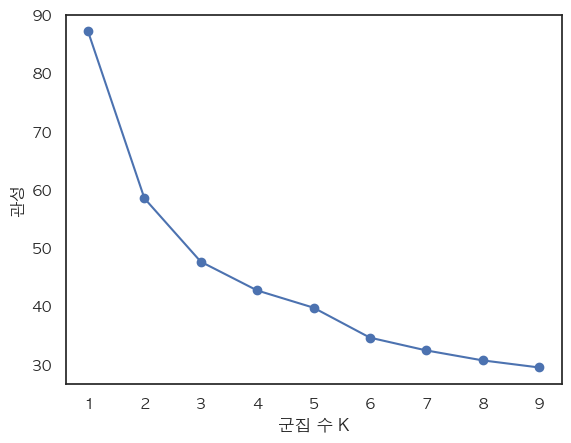

In [106]:
plot_inertia(target_posterior)

### 2.3. 군집화 실행

In [44]:
def df_with_cluster(df: pd.DataFrame, n_cluster: int, kmeans_model):
    df_concern = df[:-1]

    # K-Means 군집화 계산
    if kmeans_model is None:
        kmeans_model = KMeans(n_clusters=n_cluster, n_init='auto')
    kmeans_model.fit(df_concern)

    # 군집 계산 결과를 기존 데이터프레임에 합체
    cluset_result = df_concern.copy()
    cluset_result["cluster"] = kmeans_model.labels_

    return cluset_result, kmeans_model

In [45]:
target_posterior_cluster, _ = df_with_cluster(df=target_posterior, n_cluster=3,
                                              kmeans_model=None)

In [46]:
target_posterior_cluster

,relative,per,pbr,dividend,small,lowvol,individual,institutional,foreign,cluster
date,,,,,,,,,,
2013-04-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
2013-04-02,1.000000,1.000000,0.993874,1.002599,0.998489,1.000000,0.989386,1.007792,0.980048,0
2013-04-03,1.000000,1.000000,0.985224,0.998689,1.011376,1.000000,0.995325,1.015885,0.987177,0
2013-04-04,1.000000,1.000000,0.986836,1.017300,1.030681,1.000000,1.018537,1.004330,0.995503,0
2013-04-05,1.000000,1.000000,0.987285,1.047079,1.059617,1.000000,1.016800,1.004358,0.993597,0
...,...,...,...,...,...,...,...,...,...,...
2021-11-24,1.017979,1.007805,1.004145,1.016726,0.995512,0.926013,1.024947,0.943342,0.966501,0
2021-11-25,1.026101,1.019896,1.018797,1.023829,1.002626,0.921670,1.023580,0.962523,0.980537,0
2021-11-26,1.022661,1.033945,1.034056,1.033649,1.038008,0.917357,1.054471,0.966210,0.992679,0


### 2.4. 군집 평가

In [171]:
def check_clustering(df: pd.DataFrame):
    # tsne 기반 차원 축소
    tsne = TSNE(n_components=2)
    reduced_data = tsne.fit_transform(df.drop(columns='cluster'))
    tsne_df = pd.DataFrame(reduced_data, columns=['component_0', 'component_1'])

    tsne_df['target'] = df['cluster'].values

    # 타겟별 분리
    tsne_df_0 = tsne_df[tsne_df['target'] == 0]
    tsne_df_1 = tsne_df[tsne_df['target'] == 1]
    tsne_df_2 = tsne_df[tsne_df['target'] == 2]

    # 타겟별 시각화
    plt.scatter(tsne_df_0['component_0'], tsne_df_0['component_1'],
                color='pink', label=f'{eng_to_kor.get("cluster")} 0')
    plt.scatter(tsne_df_1['component_0'], tsne_df_1['component_1'],
                color='purple', label=f'{eng_to_kor.get("cluster")} 1')
    plt.scatter(tsne_df_2['component_0'], tsne_df_2['component_1'],
                color='yellow', label=f'{eng_to_kor.get("cluster")} 2')

    plt.legend()
    plt.show()

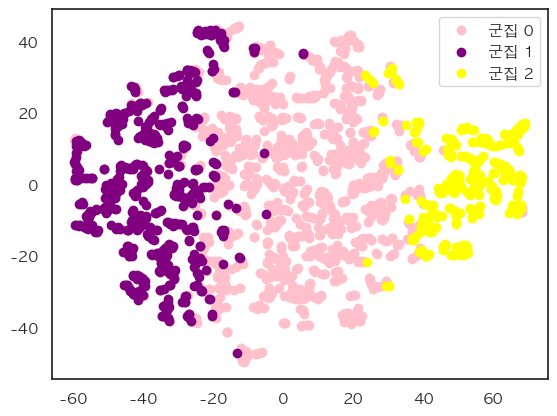

In [172]:
check_clustering(target_posterior_cluster)

In [170]:
draw_data_html(target_posterior_cluster, 'cluster')

### 2.5. 군집 및 전략별 수익률

In [50]:
def mean_return_by_cluster(df: pd.DataFrame) -> pd.DataFrame:
    return_df = pd.DataFrame(columns=['factor', 'cluster', 'mean_return'])
    # 군집 및 전략별 평균 리턴 구하기
    for factor in df.columns.drop('cluster'):
        factor_data = []
        for cycle in sorted(df.cluster.unique()):
            mean_value = (df[df.cluster == cycle][factor].mean() - 1) * 100 * 21
            factor_data.append(
                {'factor': factor, 'cluster': cycle, 'mean_return': mean_value})
        return_df = pd.concat([return_df, pd.DataFrame(factor_data)])

    return return_df

In [51]:
cluster_return_df = mean_return_by_cluster(target_posterior_cluster)

In [52]:
cluster_return_df

,factor,cluster,mean_return
0,relative,0,3.137571
1,relative,1,119.366135
2,relative,2,-154.042597
0,per,0,1.827229
1,per,1,116.562414
2,per,2,-119.040868
0,pbr,0,7.126941
1,pbr,1,132.937791
2,pbr,2,-147.707108
0,dividend,0,9.919636


#### 2.5.1 군집 및 전략별 평균 수익률 시각화

In [127]:
def cluster_heatmap(df: pd.DataFrame, var_sort: bool = False):
    df = df.rename(columns=eng_to_kor)
    # 히트맵을 위한 데이터프레임 재구조화
    pivot_df = df.pivot_table(index=eng_to_kor.get('factor'),
                              columns=eng_to_kor.get('cluster'),
                              values='mean_return')
    pivot_df = pivot_df.rename(index=eng_to_kor)
    # 평균 수익률로 정렬
    if var_sort:
        pivot_df = pivot_df.sort_values(by=[pivot_df.var().idxmax()])
    plt.figure(figsize=(pivot_df.shape[0], int(pivot_df.shape[1]) * 2))
    ax = sns.heatmap(pivot_df, xticklabels=True, yticklabels=True)

    return ax

<Axes: xlabel='군집', ylabel='전략'>

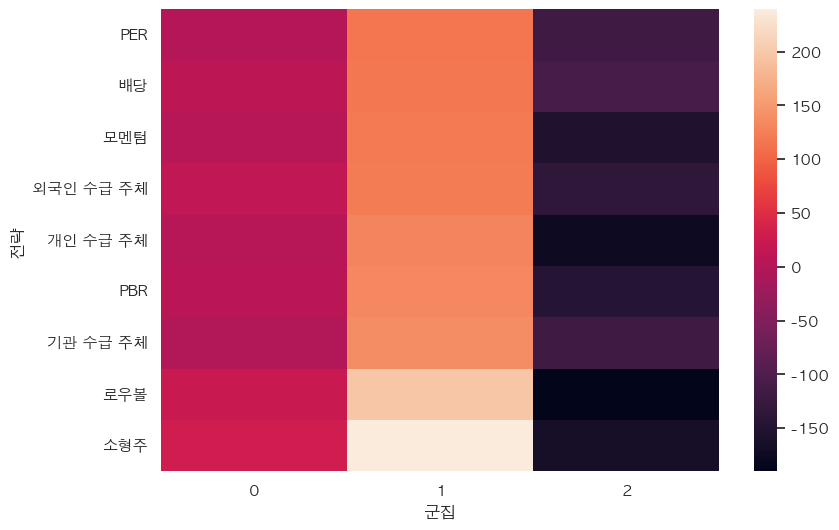

In [151]:
cluster_heatmap(df=cluster_return_df, var_sort=True)

### 2.6. 군집별 전략 가중치

In [190]:
def get_strategy_weight(df: pd.DataFrame, min_weight: float) -> pd.DataFrame:
    # 데이터프레임 재구조화
    pivot_df = df.pivot_table(index='factor', columns='cluster',
                              values='mean_return')
    # 최소 가중치 제약 조건
    assert len(pivot_df) <= 1 / min_weight, \
        f'min weight too big({min_weight}) for {len(pivot_df)} factors'

    # 전체가 음수인 군집의 경우 양수로 바꾸고 역수를 취함
    negative_column = pivot_df.columns[(pivot_df < 0).all()]
    for column in negative_column:
        pivot_df[column] = 1 / -pivot_df[column]

    # 음수 제거(0으로 대체)
    pivot_df.clip(lower=0, inplace=True)
    cluster_variable_pair = defaultdict(list)

    # 국면별로 전략 가중치 계산 시작
    for cluster in pivot_df.columns:
        variables = pivot_df[cluster]

        # 무보정 전략 가중치 계산
        normalized = variables / variables.sum()
        normalized.fillna(0, inplace=True)

        # 최소 가중치보다 가중치가 적은 전략이 최소 가중치를 갖게 수정
        less_than_min = normalized[normalized < min_weight]
        normalized[less_than_min.keys()] = min_weight

        # 최소 가중치 전략(less_than_min) 제외한 나머지 가중치로 다시 전략 가중치 계산
        need_adjust = variables.keys().difference(less_than_min.keys())
        available_weight = 1 - (min_weight * len(less_than_min))
        normalized[need_adjust] = normalized[need_adjust] * available_weight

        # 유효숫자 재설정
        normalized = normalized.round(2)

        # 가중치 재설정 시 생긴 오차를 제일 큰 가중치를 가진 전략에서 교정
        residual = 1 - normalized.sum()
        normalized[normalized.argmax()] += residual

        cluster_variable_pair[cluster] = normalized

    return pd.DataFrame.from_dict(cluster_variable_pair)

In [191]:
factor_weight_by_cluster = get_strategy_weight(df=cluster_return_df,
                                               min_weight=0.01)

In [193]:
factor_weight_by_cluster

,0,1,2
factor,,,
dividend,0.11,0.09,0.15
foreign,0.15,0.09,0.11
individual,0.03,0.10,0.09
institutional,0.01,0.11,0.13
lowvol,0.25,0.15,0.08
pbr,0.08,0.10,0.11
per,0.02,0.09,0.13
relative,0.03,0.09,0.10
small,0.32,0.18,0.10


## 3. 국면 예측

In [227]:
target = pd.read_csv('factor/factor_asset.csv', index_col=0)
portfolio = pd.read_csv('factor/factor_portfolio.csv', index_col=0)

In [59]:
min_weight = 0.01

fromdate = '2014-04-01'
todate = '2021-11-30'
splitdate = '2017-03-31'

n_cluster = 3

### 3.1. 데이터 슬라이싱

In [60]:
def df_within_date(df: pd.DataFrame, fromdate: str, todate: str):
    if 'date' in df.columns:
        df.set_index('date', inplace=True)

    return df[fromdate:todate]

In [61]:
macro_df = df_within_date(df=macro, fromdate=fromdate, todate=todate)
target_df = df_within_date(df=target, fromdate=fromdate, todate=todate)

In [62]:
target_df_posterior = factor_1month_return(target_df)

In [63]:
def downsample_df(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    data['date'] = data.index
    data = data.resample('M').apply('last')

    return data.set_index(pd.DatetimeIndex(data.date)).drop(columns=['date'])

In [64]:
target_df_posterior = downsample_df(target_df_posterior)
macro_df = downsample_df(macro_df)

### 3.2. 랜덤 포레스트를 통한 국면 예측

#### 3.2.1. 랜덤 포레스트 함수

In [65]:
def train_RF(train_x: pd.DataFrame, train_y: pd.DataFrame, random_state: int):
    train_x_concern = train_x[:-1]
    y_train = train_y[['cluster']]
    x_train = train_x_concern[:max(y_train.index)]

    # 랜덤포레스트 모델 피팅
    rf = RandomForestClassifier(n_estimators=50, random_state=random_state)
    rf.fit(x_train, y_train.values.ravel())

    return rf

#### 3.2.2. 점진 학습

In [66]:
def incremental_split(df: pd.DataFrame, split_date: str,
                      loop: int) -> pd.DataFrame:
    # 점진 학습을 위한 훈련/예측 데이터 구분점 갱신
    split_point = df.index.get_loc(split_date) + loop

    return df[:split_point]

#### 3.2.3. 개별 루프에서의 전략 가중치 저장

In [67]:
def get_strategy_weight_per_loop(df: pd.DataFrame, cluster: int,
                                 time) -> pd.DataFrame:
    single_multifactor = df[cluster].transpose()
    single_multifactor['date'] = time.values

    return single_multifactor

#### 3.2.4. 군집 및 전략별 가중치 예측

In [68]:
def cluster_weight_prediction(input_df: pd.DataFrame, target_df: pd.DataFrame,
                              split_start_date: str, n_cluster: int,
                              min_weight: float,
                              random_state: Optional[int] = 1) -> tuple:
    # 군집 및 전략 가중치 저장 데이터프레임 생성
    predictions = np.array([])
    reals = np.array([])
    real_multifactor = pd.DataFrame()
    pred_multifactor = pd.DataFrame()
    kmeans_model = None

    for loop in tqdm(range(target_df.loc[split_start_date:].shape[0])):
        # 점진 학습을 위한 데이터프레임 슬라이싱
        macro_split = incremental_split(input_df, split_start_date, loop)
        target_posterior_split = incremental_split(target_df, split_start_date, loop)
        # K-Means 군집화 수행 및 모델 추출
        target_posterior_cluster, kmeans_model = df_with_cluster(
            df=target_posterior_split,
            n_cluster=n_cluster,
            kmeans_model=kmeans_model)
        # 거시 경기 데이터를 사용해 랜덤 포레스트 학습
        model = train_RF(macro_split, target_posterior_cluster,
                         random_state=random_state)
        # 랜덤 포레스트를 통해 군집 예측 및 실제 군집 저장
        pred_cluster = model.predict(macro_split.iloc[-1:])
        real_cluster = kmeans_model.predict(target_posterior_split.iloc[-1:])
        # 가중치 분배를 위한 군집 및 전략별 평균 수익률 계산
        cluster_return_df = mean_return_by_cluster(target_posterior_cluster)
        # 전략별 가중치 계산
        factor_weight_by_cluster = get_strategy_weight(df=cluster_return_df,
                                                       min_weight=min_weight)
        # 히트맵을 위한 날짜 추출
        multifactor_time = macro_split.iloc[-1:].index
        # 멀티 팩터용 전략별 가중치 저장
        pred_row = get_strategy_weight_per_loop(df=factor_weight_by_cluster,
                                                cluster=pred_cluster,
                                                time=multifactor_time)
        real_row = get_strategy_weight_per_loop(df=factor_weight_by_cluster,
                                                cluster=real_cluster,
                                                time=multifactor_time)

        # 데이터프레임 통합
        predictions = np.append(predictions, pred_cluster)
        reals = np.append(reals, real_cluster)
        pred_multifactor = pd.concat([pred_multifactor, pred_row])
        real_multifactor = pd.concat([real_multifactor, real_row])

    return predictions, reals, pred_multifactor, real_multifactor

In [220]:
preds, reals, pred_weight, real_weight = cluster_weight_prediction(
    x_df=macro_df,
    y_df=target_df_posterior,
    split_start_date=splitdate,
    n_cluster=n_cluster,
    min_weight=min_weight)

100%|██████████| 57/57 [00:02<00:00, 22.51it/s]


### 3.3. 예측 평가하기

#### 3.3.1. 군집 예측 평가

In [221]:
def draw_real_pred_plot(pred: np.array, real: np.array):
    plt.figure(figsize=(15, 4))
    x = np.arange(0, len(pred), 1)
    plt.plot(x, real, label=f'{eng_to_kor.get("real")}')
    plt.plot(x, pred, label=f'{eng_to_kor.get("pred")}')
    plt.legend()
    plt.show()

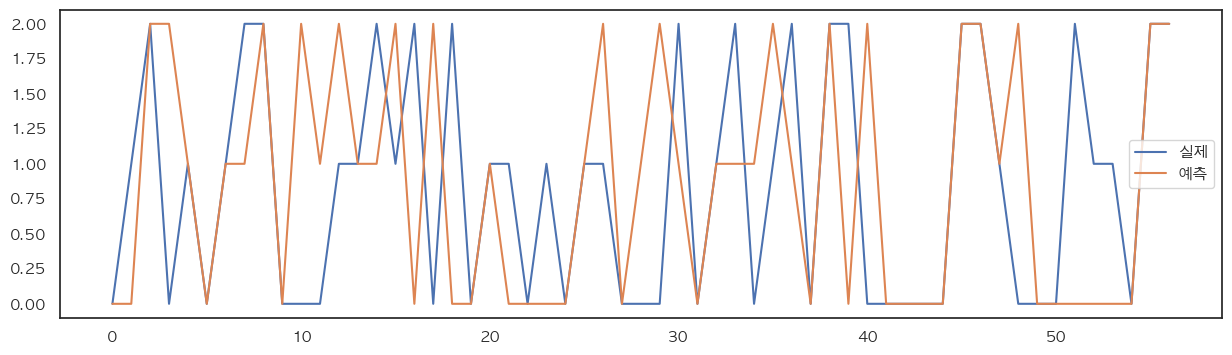

In [222]:
draw_real_pred_plot(preds, reals)

In [223]:
def draw_confusion_heatmap(pred: np.array, real: np.array):
    # Scikit_learn의 accuracy_score 사용
    accuracy = accuracy_score(pred, real)

    plt.figure()
    cm = pd.DataFrame(confusion_matrix(pred, real))
    ax = sns.heatmap(cm, annot=True)
    ax.set(xlabel=f'{eng_to_kor.get("real")}',
           ylabel=f'{eng_to_kor.get("pred")}',
           title=f'{eng_to_kor.get("accuracy")}:{accuracy}')
    plt.show()

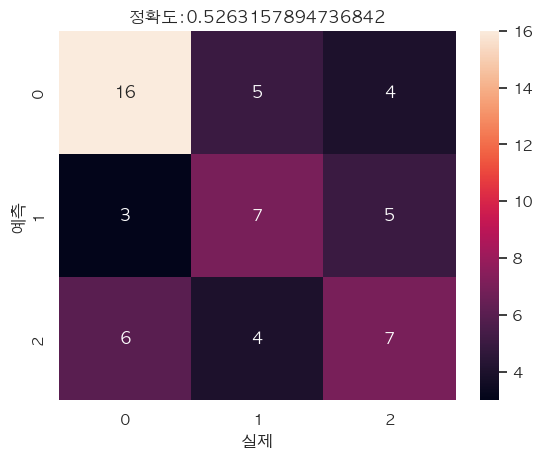

In [224]:
draw_confusion_heatmap(preds, reals)

#### 3.3.2. 가중치 예측 시각화

In [162]:
def draw_factor_weight(df: pd.DataFrame):
    df_copy = df.sort_values(by=['date'], ascending=False).copy()
    df_copy['date'] = df_copy['date'].dt.strftime("%Y%m")
    df_copy.index = df_copy['date']
    df_copy.drop(columns=['date'], inplace=True)

    sns.set_theme(style='white')
    plt.figure(figsize=(df_copy.shape[1] / 2, df_copy.shape[0] / 3))
    ax = sns.heatmap(df_copy, xticklabels=True, yticklabels=True)
    plt.show()

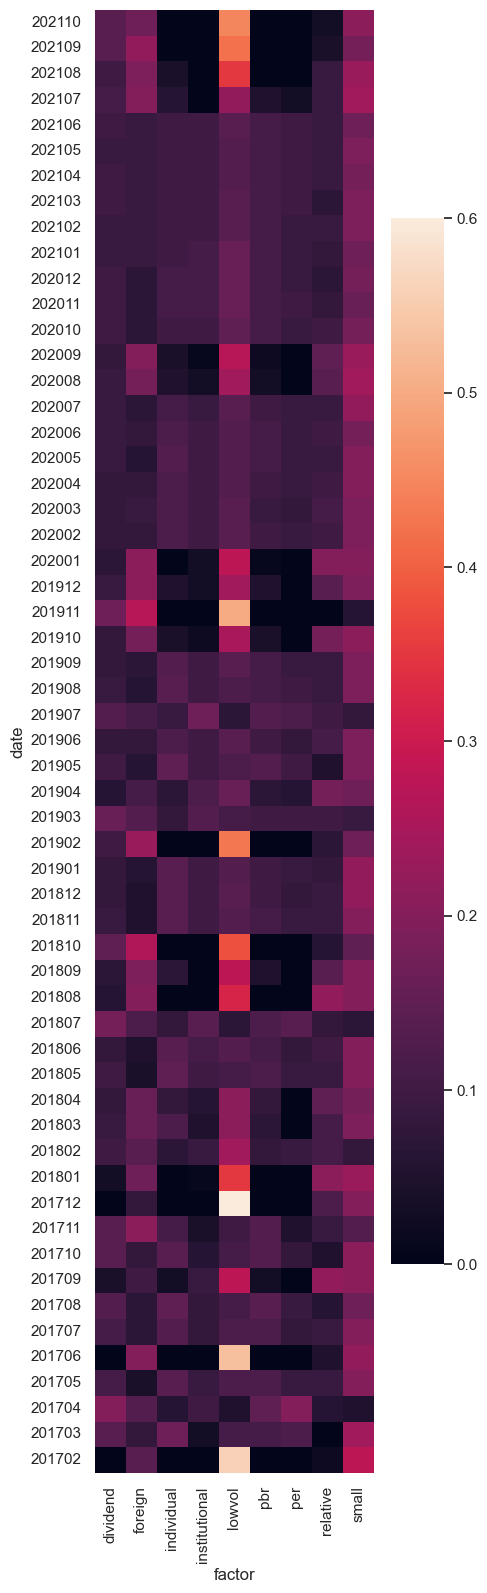

In [163]:
draw_factor_weight(pred_weight)

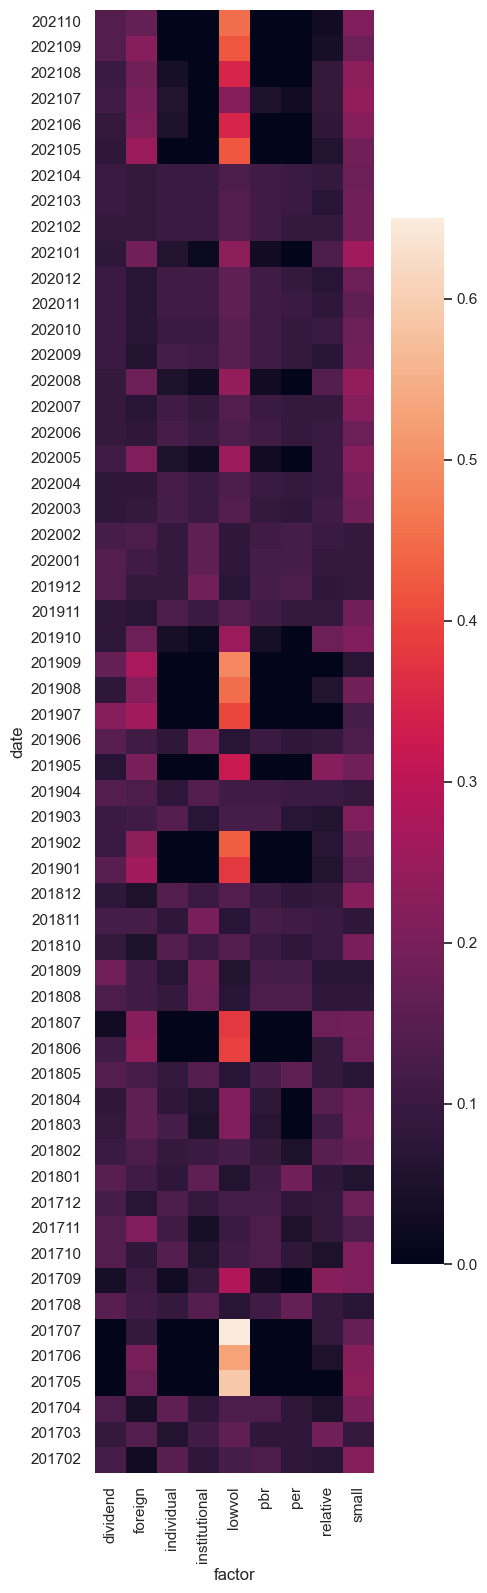

In [76]:
draw_factor_weight(real_weight)

## 4. 포트폴리오 준비

### 4.1. 전체 합을 1에 가깝게 조정

In [77]:
def sum_adjust(df: pd.DataFrame):
    # 합쳐서 1이 아닌 가중치 선별 및 차이 계산
    df_sum = df.groupby('date').sum()
    need_adj = df_sum[~df_sum['weight'].between(0.9, 1)]
    need_adj_copy = need_adj.copy()
    need_adj_copy['difference'] = need_adj_copy.weight - 1
    # 보정
    for date, diff in zip(need_adj_copy.index, need_adj_copy.difference):
        locator = df[df.date == date]
        location = locator[locator.weight > 0].idxmin().weight
        df.loc[location, 'weight'] -= diff

    return df

### 4.2. 팩터별 가중치와 포트폴리오 합산

In [78]:
def ticker_weight(factor_weight_df: pd.DataFrame,
                  portfolio_df: pd.DataFrame) -> pd.DataFrame:
    # 비중 테이블 unpivot
    weight_melt = pd.melt(factor_weight_df, id_vars=['date'],
                          value_vars=factor_weight_df.columns[:-1])
    weight_melt = weight_melt.sort_values(by=['date', 'factor']).reset_index(
        drop=True)
    # 포트폴리오 테이블 준비
    portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])
    # 합치기
    merged_df = pd.merge(portfolio_df, weight_melt, how='left',
                         left_on=['date', 'factor'], right_on=['date', 'factor']
                         ).dropna()
    merged_df['weight'] = merged_df.weight * merged_df.value
    merged_df_grouped = merged_df[['date', 'ticker', 'weight']].groupby(
        ['date', 'ticker']).sum().reset_index()
    # 유효숫자 설정
    merged_df_grouped.weight = round(merged_df_grouped.weight, 4)

    return sum_adjust(merged_df_grouped)

In [182]:
portfolio

,date,ticker,weight,factor
0,2013-04-30,270,0.0,dividend
105,2013-04-30,660,0.0,dividend
210,2013-04-30,720,0.0,dividend
315,2013-04-30,810,0.0,dividend
420,2013-04-30,880,0.0,dividend
...,...,...,...,...
6614,2021-12-30,128940,0.0,small
6719,2021-12-30,138040,0.0,small
6824,2021-12-30,138930,0.0,small
6929,2021-12-30,139480,0.0,small


In [180]:
real_weight

factor,dividend,foreign,individual,institutional,lowvol,pbr,per,relative,small,date
1,0.12,0.03,0.15,0.08,0.12,0.13,0.08,0.07,0.22,2017-02-28
0,0.09,0.14,0.06,0.11,0.16,0.08,0.08,0.19,0.09,2017-03-31
0,0.13,0.04,0.16,0.08,0.13,0.13,0.08,0.05,0.20,2017-04-28
2,0.00,0.18,0.00,0.00,0.59,0.00,0.00,0.00,0.23,2017-05-31
2,0.00,0.20,0.00,0.00,0.53,0.00,0.00,0.05,0.22,2017-06-30
0,0.00,0.09,0.00,0.00,0.65,0.00,0.00,0.09,0.17,2017-07-31
1,0.15,0.11,0.09,0.14,0.07,0.11,0.17,0.09,0.07,2017-08-31
2,0.04,0.10,0.03,0.09,0.28,0.03,0.00,0.22,0.21,2017-09-29
2,0.14,0.08,0.14,0.06,0.11,0.13,0.08,0.05,0.21,2017-10-31
1,0.14,0.21,0.11,0.04,0.10,0.13,0.05,0.09,0.13,2017-11-30


In [79]:
ticker_weight_real = ticker_weight(factor_weight_df=real_weight,
                                   portfolio_df=portfolio)
ticker_weight_pred = ticker_weight(factor_weight_df=pred_weight,
                                   portfolio_df=portfolio)

In [166]:
ticker_weight_real.to_csv('factor/ticker_weight_real.csv')
ticker_weight_pred.to_csv('factor/ticker_weight_pred.csv')